In [ ]:
# Imports
from cytotools.read import read_from_disk, polars_to_pandas
from cytotools.dimension_reduction import DimensionReduction
from cytotools.transform import apply_transform
from cytocluster.single import SingleClustering
from cytocluster.methods.utils import build_clustering_method
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="ticks", font_scale=1.3)
%matplotlib inline

# Individual clustering

In this example notebook I will show how you can use CytoCluster to perform clustering analysis using popular algorithms from the cytometry literature.

## Preparing example data

I'm going to use the Levine-32 dataset from here (https://github.com/lmweber/benchmark-data-Levine-32-dim)

In [ ]:
# Read the Levine32 FCS file from disk
# By default, CytoTools reads data in as Polars dataframe, but we can easily convert to a Pandas DataFrame
data = polars_to_pandas(read_from_disk("data/Levine_32dim_notransform.fcs"))
data.head()

In [ ]:
# Replace the labels with more intuitive population names
populations = pd.read_csv("data/levine32_populations.csv")
mappings = {x["label"]: x["population"] for x in populations.to_dict("records")}
data["label"] = data["label"].replace(mappings)
data.rename(columns={"label": "Ground Truth", "individual": "sample_id"}, inplace=True)

For the purposes of this tutorial, I'm going to remove events that do not have a ground truth label.

In [ ]:
data = data[~data["Ground Truth"].isnull()].copy()

## Prepare a clustering object

The `SingleClustering` class from CytoCluster provides all the functionality for applying a single clustering algorithm to data and generating cluster labels. In the next notebook titled "Ensemble clustering" I will use the `EnsembleClustering` class to combine multiple clustering labels to generate a final clustering solution.

A `SingleClustering` object can be constructed using the `from_dataframe` method. **Note: the data must contain a column called 'sample_id'**, this is why in the code cell above I renamed the column 'individual'.

Then the `transform` method can be used to apply a transformation to our features - we will apply a Arcsinh transform with a cofactor of 100.

In [ ]:
features = [
    'CD45RA', 'CD133', 'CD19', 'CD22', 'CD11b', 'CD4', 'CD8', 'CD34',
    'Flt3', 'CD20', 'CXCR4', 'CD235ab', 'CD45', 'CD123', 'CD321',
    'CD14', 'CD33', 'CD47', 'CD11c', 'CD7', 'CD15', 'CD16', 'CD44',
    'CD38', 'CD13', 'CD3', 'CD61', 'CD117', 'CD49d', 'HLA-DR', 'CD64', 'CD41'
]

clustering = SingleClustering.from_dataframe(
    data=data,
    features=features,
    verbose=True,
    random_state=42,
    pre_embedded=False
)

Note that I set `pre_embedded` to False. This means that I have not already performed dimension reduction and no columns in the dataframe correspond to latent variables generated by a technique such as tSNE or UMAP. I will come back to this later but for now we will leave this as False.

In [ ]:
# I can either specify which features to transform by passing a list of column names to the 'features' argument
# or leave 'features' as None, transforming all the features specified when I constructed the object
clustering.transform_features(method="asinh", cofactor=100)

In [ ]:
clustering

We now have a `Clustering` object that has a bunch of functions that make clustering cytometry data and visualising results easy. The main property of interest on this object is `data`. This will store the results:

* cluster_label: this column will contain the cluster labels
* meta_label: this will contain meta cluster labels (meta clustering in this context is where each sample is clustered individually and then the clusters from all individuals are clustered into meta-clusters. This is beyond the scope of this tutorial but for further details see the Phenograph paper, Levine et al 2015, or CytoPy paper, Burton et al 2021).

In [ ]:
clustering.data.head()

The 'embedding cache' attribute (currently False) specifies whether a dimension reduction technique has been applied and the results cached for plotting. I will discuss this next.

## Dimension reduction and plotting

One of the common tasks when performing clustering analysis is plotting the data for visualisation. For this we often use techniques like tSNE, UMAP, or PHATE to reduce the dimensionality of our data. These techniques tend to be computationally expensive, therefore the `Clustering` class implements two features:

* Downsampling to reduce the complexity of this task - sampling is performed per sample ID so that each individual is equally represented
* Caching of results so that expensive computations don't have to be repeated

Whenever the chosen dimension reduction method is changed, the cache is overwritten, however we can manually overwrite the cache by specifying the `overwrite_cache` argument to True when performing dimension reduction.

Below I call the `dimension_reduction` method to generate 2 UMAP features. By specifying a sample size of 10000, this ensures that 5000 events are sampled from each patient, giving me a total of 20000 data points in my embedding. The function returns a DataFrame with the columns UMAP1 and UMAP2, this dataframe is what is cached within the `Clustering` object.

In [ ]:
embeddings = clustering.dimension_reduction(n=10000, method="UMAP", n_components=2, random_state=42)
embeddings.head()

With the embeddings cached, I can now call our plotting methods to visualise the data, starting with a density plot:

In [ ]:
# Because the dimension reduction method hasn't changed and 'overwrite_cache' is False, it will use the cached embeddings to generate
# this plot
clustering.plot_density(method="UMAP", overwrite_cache=False, bins=200)
plt.show()

The `plot` function allows for plotting any label of choice on your data, so I can plot the ground truth labels for example:

In [ ]:
clustering.plot(
    label="Ground Truth",
    discrete=True,
    method="UMAP",
    overwrite_cache=False,
    include_legend=True,
    legend_kwargs=dict(bbox_to_anchor=(1.0, 1.0))
)
plt.show()

In [ ]:
clustering.data

You can also plot continuous variables:

In [ ]:
clustering.plot(
    label="CD3",
    discrete=False,
    method="UMAP",
    overwrite_cache=False,
)
plt.show()

I mentioned before that you can perform dimension reduction prior to constructing you clustering object. This might be preferable if you have sufficient computer power because you can generate embeddings for all available data. This is often beyond the resource available for experiments with many subjects and millions of data points.

If I were to do this, I can use the `DimensionReduction` class from CytoTools.

In [ ]:
reducer = DimensionReduction(method="UMAP", n_components=2, n_jobs=-1, n_neighbors=30)
data_with_embeddings = apply_transform(data=data.copy(), features=features, method="asinh", cofactor=100)
data_with_embeddings = reducer.fit_transform(data=data_with_embeddings, features=features)

I now reconstruct my `Clustering` object but this time I specify `pre_embedded` as True. This now means that for all plotting the pre-computed embeddings will be used and caching will be ignored. I could also optionally set the features to the UMAP embeddings, meaning that clustering would be performed on the embeddings rather than the original features.

Clustering on the latent variables can also be achieved with the `LatentClustering` class in CytoCluster which allows for down-sampling to overcome computational complexity and subsequent upsampling by K-nearest neighbours, similar to the SPADE algorithm.

In [ ]:
clustering = SingleClustering.from_dataframe(
    data=data_with_embeddings,
    features=features,
    verbose=True,
    random_state=42,
    pre_embedded=True
)

In [ ]:
clustering

All the same plots can be generated but now with more data and

In [ ]:
clustering.plot_density(bins=250)

In [ ]:
clustering.plot(
    label="Ground Truth",
    discrete=True,
    method="UMAP",
    overwrite_cache=False,
    include_legend=True,
    legend_kwargs=dict(bbox_to_anchor=(1.0, 1.0))
)
plt.show()

In [ ]:
clustering.plot(
    label="CD3",
    discrete=False,
    method="UMAP",
    overwrite_cache=False
)
plt.show()

## Clustering analysis

Clustering analysis can be performed with one of the three following methods:

* local_clustering: clusters data grouped on sample ID, meaning each individual is clustered separately and the cluster labels are relative to the sample ID.
* meta_clustering: to be performed after local clustering, the clusters from each individual are clustered into meta-clusters of similar phenotype.
* global_clustering: all data is clustered together.

In this notebook I will only be covering global clustering as that is the most common technique used and relevant to the wider audience.

CytoCluster exposes some of the most popular clustering algorithms but supports any clustering algorithm that has Scikit-Learn signatures. The clustering algorithm itself is wrapped by the `ClusterMethod` class, but for convenience we only have to pass either a valid clustering object (e.g. KMeans object from Scikit-Learn) or a string value. If we pass a string it should be one of the following supported methods:

* phenograph - graph based clustering using community detection (Louvain method)
* parc - optimised version of phenograph
* flowsom - self-organising maps
* spade - density-dependent down sampling with hierarchical clustering and then up sampling by nearest
neighbours
* k_consensus - consensus clustering with automated selection of K
* latent - choice of any ClusterMethod but applied to embedding from a method such as UMAP, tSNE or PHATE

Below I'm going to show an example from each of the most popular methods as well as some Scikit-Learn algorithms.

In [ ]:
clustering = SingleClustering.from_dataframe(
    data=data_with_embeddings.sample(10000),
    features=features,
    verbose=True,
    random_state=42,
    pre_embedded=True
)

### FlowSOM

Starting with FlowSOM, I call global clustering and simply specify our method as "flowsom". The `clustering_params` argument takes a dictionary of values that are passed onto the FlowSOM algorithm.

In [ ]:
clustering.global_clustering(
    method="flowsom",
    clustering_params=dict(
        som_dim=(15, 15), learning_rate=0.4, batch_size=100, sigma=0.1
    )
)

This will populate our `Clustering` object with labels and I can plot the results as before.

In [ ]:
clustering.plot_cluster_membership(include_legend=True, legend_kwargs=dict(bbox_to_anchor=(1.0, 1.0)))

Becauce I created this `Clustering` object with data that has UMAP embeddings stored as columns, I can include the `overwrite_features` parameter and tell FlowSOM to cluster the UMAP features instead of the original features.

In [ ]:
clustering.global_clustering(
    method="flowsom",
    overwrite_features=["UMAP1", "UMAP2"],
    clustering_params=dict(
        som_dim=(15, 15), learning_rate=0.4, batch_size=100, sigma=0.1
    )
)

In [ ]:
clustering.plot_cluster_membership(include_legend=True, legend_kwargs=dict(bbox_to_anchor=(1.0, 1.0)))

If I did not have the UMAP embeddings available, perhaps due to computational resource contraints, I can use the 'latent' clustering tool to perform FlowSOM on UMAP embeddings on a smaller sample of may data (which would be less computationally intensive) and then upsample the cluster labels using a nearest neighbours model:

In [ ]:
flowsom_params = dict(
    som_dim=(15, 15), learning_rate=0.4, batch_size=100, sigma=0.1
)

clustering.global_clustering(
    method="latent",
    clustering_params=dict(
        cluster_method=build_clustering_method("flowsom", **flowsom_params),
        dimension_reduction=DimensionReduction(method="UMAP", n_components=2),
        sample_size=1000
    )
)

In [ ]:
clustering.plot_cluster_membership(include_legend=True, legend_kwargs=dict(bbox_to_anchor=(1.0, 1.0)))

If we want to look at the expression profile of our clusters, we just have to use the `heatmap` method after calling a clustering method (remember calling the clustering method populates the cluster labels).

In [ ]:
clustering.heatmap(meta_label=False, cmap="coolwarm", standard_scale=1)

If we have lots of individuals (indicated by sample_id column) in our data we might be interested in whether clusters are dominated by a single individual. For this we can use the `simpons_diversity_index` method. 

In [ ]:
clustering.simpsons_diversity_index().head()

We can also plot this data. Below larger values indicate less diversity within the cluster (because simpsons index is the probability that two randomly chosen events from a cluster will be from the same individual).

In [ ]:
clustering.plot_simpsons_diversity_index()

There are other useful methods such as `cluster_proportions` which creates a box and swarm plot where each data point is an individual. If we have additional columns in our data that we want to use as categories, we can pass them in as the `hue` argument. 

In [ ]:
clustering.cluster_proportions()

Sometimes it can be useful to look at the quality of clusters using some internal metric. The `internal_performance` method generates a dataframe of common internal metrics using a bootstrap resampling procedure. The `performance` method performs the same operation but returns a dictionary of results (instead of a dataframe) and returns a plot of each metric.

In [ ]:
clustering.internal_performance(sample_n=2500, resamples=10)

In [ ]:
results, fig = clustering.performance(sample_n=2500, resamples=10)

In [ ]:
fig.tight_layout()
fig

### Phenograph

Example of phenograph clustering:

In [ ]:
clustering.global_clustering(method="phenograph")

In [ ]:
clustering.plot_cluster_membership(include_legend=True, legend_kwargs=dict(bbox_to_anchor=(1.0, 1.0)))

### SPADE

Example of SPADE clustering:

In [ ]:
clustering.global_clustering(method="spade", clustering_params=dict(sample_size=1000, min_k=5, max_k=10))

In [ ]:
clustering.plot_cluster_membership(include_legend=True, legend_kwargs=dict(bbox_to_anchor=(1.0, 1.0)))

### PARC

Example of PARC clustering, an optimised version of phenograph for faster runtimes:

In [ ]:
clustering.global_clustering(method="parc", clustering_params=dict(smallest_population=100, max_cluster_size=0.5))

In [ ]:
clustering.plot_cluster_membership(include_legend=True, legend_kwargs=dict(bbox_to_anchor=(1.0, 1.0)))

### Using a Scikit-Learn like clustering algorithm

You can also use any class for clustering so long as it implements the common Scikit-Learn API i.e. a `fit_transform` method. In the example below I apply DBSCAN clustering to the UMAP features.

### SPADE

Example of SPADE clustering:

In [91]:
clustering.global_clustering(method="spade", clustering_params=dict(sample_size=1000, min_k=5, max_k=10))

  0%|          | 0/6 [00:00<?, ?it/s]

Clustering object
data: 10000 observations, 32 features, 45 columns
N samples: 2
pre-embedded latent variables: True
embeddings cache: False

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

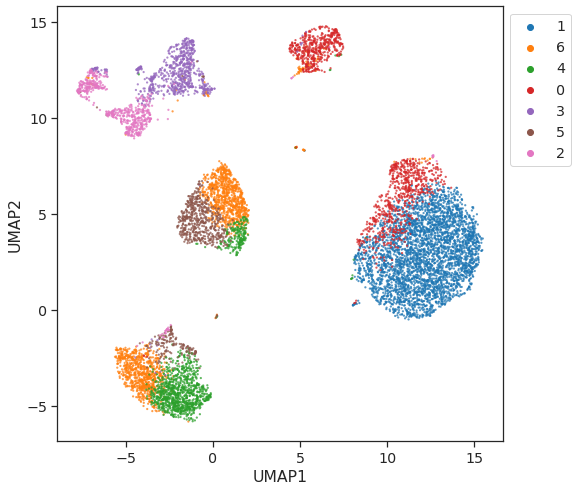

In [92]:
clustering.plot_cluster_membership(include_legend=True, legend_kwargs=dict(bbox_to_anchor=(1.0, 1.0)))

### PARC

Example of PARC clustering, an optimised version of phenograph for faster runtimes:

In [94]:
clustering.global_clustering(method="parc", clustering_params=dict(smallest_population=100, max_cluster_size=0.5))

Clustering object
data: 10000 observations, 32 features, 45 columns
N samples: 2
pre-embedded latent variables: True
embeddings cache: False

Palette requires more than 20 unique colours, be careful interpreting results!
/home/ross/.cache/pypoetry/virtualenvs/cytocluster-9ecCQAJO-py3.8/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

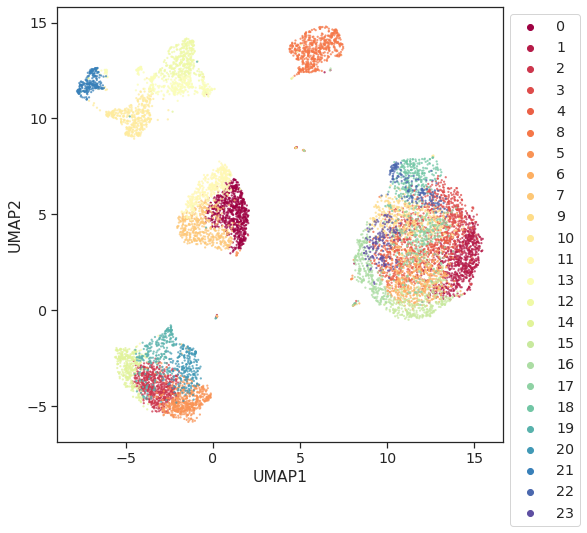

In [95]:
clustering.plot_cluster_membership(include_legend=True, legend_kwargs=dict(bbox_to_anchor=(1.0, 1.0)))

### Using a Scikit-Learn like clustering algorithm

You can also use any class for clustering so long as it implements the common Scikit-Learn API i.e. a `fit_transform` method. In the example below I apply DBSCAN clustering to the UMAP features.

In [109]:
from sklearn.cluster import DBSCAN
clustering.global_clustering(method=DBSCAN(eps=0.5, min_samples=10), overwrite_features=["UMAP1", "UMAP2"])

Clustering object
data: 10000 observations, 32 features, 45 columns
N samples: 2
pre-embedded latent variables: True
embeddings cache: False

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

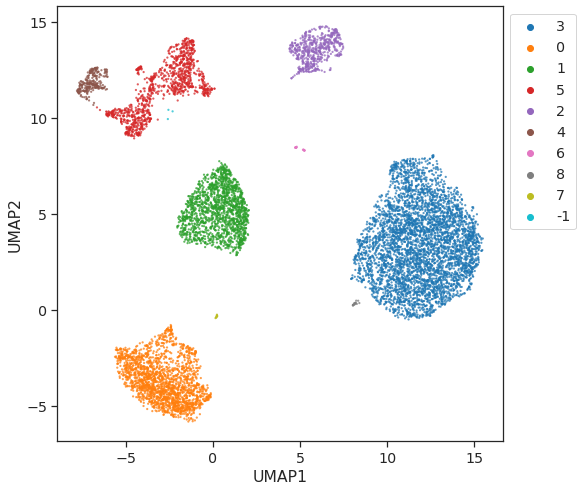

In [110]:
clustering.plot_cluster_membership(include_legend=True, legend_kwargs=dict(bbox_to_anchor=(1.0, 1.0)))